In [1]:
import os
import pickle
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from PIL import Image
import cv2
from tqdm import tqdm

Using TensorFlow backend.


# Skin Disease Model

In [2]:
os.listdir('data')

['augmentImageNameLabels.csv',
 'aumented_skindisease',
 'ISIC_2019_Training_Input',
 'Skin Disease Dataset-20200416T224355Z-001.zip',
 'SkinDiseaseDataset']

In [3]:
gnd_truth = pd.read_csv("data\SkinDiseaseDataset\ISIC_2019_Training_GroundTruth.csv")
aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))

# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


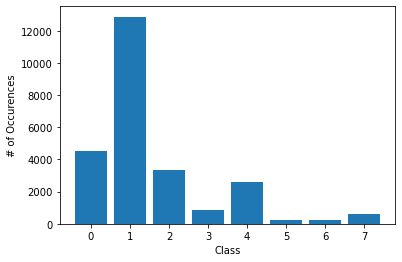

In [4]:
c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.bar(c,freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [5]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

In [6]:
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    smpl_train_idxs += list(idxs[:int(0.75*len(idxs))])
    smpl_test_idxs += list(idxs[int(0.75*len(idxs)):])



paths_aug = ["data/aumented_skindisease/"+m for m in  list(aug_df["filename"])]
paths_o = list(np.array(
    [ "data/ISIC_2019_Training_Input/"+m+'.jpg' for m in IMG_NAMES])[smpl_train_idxs])
paths = np.array(paths_o + paths_aug)
paths_o = list(np.array([ "data/ISIC_2019_Training_Input/"+m+'.jpg' for m in IMG_NAMES]))
classes =  np.array(
    list(np.argmax(labels, axis =1)[smpl_train_idxs]) + list(aug_df["class"])).astype(str)
#indexes1 = np.random.RandomState(seed = 42).permutation(len(paths_o))
#train_idx, test_idx = list(indexes1[:int(.75*pop)]), list(indexes1[int(.75*pop):]) 

In [7]:
im_size =200
channels = 3
num_classes = 8
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 8

In [8]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths,
                        "class": classes})
test_df = pd.DataFrame({"filename":np.array(paths_o)[smpl_test_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_test_idxs].astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size)
)

Found 96665 validated image filenames belonging to 8 classes.
Found 6335 validated image filenames belonging to 8 classes.


In [9]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
model = models.Sequential()
#model.add(layers.UpSampling2D((2,2)))
#model.add(layers.UpSampling2D((2,2)))
#model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(8, activation='softmax'))

In [11]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_generator, epochs=3,
                                       validation_data=test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12084 steps, validate for 792 steps
Epoch 1/3
12084/12084 [==============================] - 2623s 217ms/step - loss: 0.3790 - acc: 0.8676 - val_loss: 0.3552 - val_acc: 0.8686
Epoch 2/3
12084/12084 [==============================] - 2588s 214ms/step - loss: 0.3242 - acc: 0.8812 - val_loss: 0.3668 - val_acc: 0.8648
Epoch 3/3
12084/12084 [==============================] - 2583s 214ms/step - loss: 0.2928 - acc: 0.8901 - val_loss: 0.4325 - val_acc: 0.8524
